# Analysis notebook for the thesis

Basic descriptive statistics are adopted from the SWORDS framework. The implementation for Utrecht University can be found here: https://github.com/UtrechtUniversity/SWORDS-UU

- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

### First, configure modules like pandas and plotting libraries.

In [1]:
import glob
import time
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


Folders and constants

In [105]:
fp_figs = Path("figs")
fp_figs_extra = Path("figs", "extra")
fp_tables= Path("tables")
fp_data = Path("data")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)
fp_tables.mkdir(exist_ok=True)
fp_figs_extra.mkdir(exist_ok=True)


fp_annotated_users = Path(fp_data, "users_labeled.xlsx")
fp_repos = Path(fp_data, "repositories_labeled_faculty.xlsx")

fp_commits = Path(fp_data, "commits.csv")
fp_contributors = Path(fp_data, "contributors.csv")
fp_howfairis = Path(fp_data, "howfairis.csv")
fp_languages = Path(fp_data, "languages.csv")
fp_readme_variables = Path(fp_data, "readme_variables.csv")
fp_test_paths = Path(fp_data, "test_paths.csv")
fp_topics = Path(fp_data, "topics.csv")
fp_versions = Path(fp_data, "versions.csv")

## Analysis of user collection

- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Repository analysis](#Analysis-of-repository-collection)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

### Load users

In [3]:
df_annotated_users = pd.read_excel(fp_annotated_users)

df_annotated_users.head()

,user_id,source,service,date,id,node_id,avatar_url,gravatar_id,url,html_url,...,is_research_group,final_decision,note,employee_type,faculty,level1,level2,level3,level4,position
0,73616e646572,profile_page_uu.csv,github.com,2022-07-13,6605233,MDQ6VXNlcjY2MDUyMzM=,https://avatars.githubusercontent.com/u/660523...,NaN,https://api.github.com/users/73616e646572,https://github.com/73616e646572,...,0.0,1,"Collected via profile pages, therefore must be...",User,Humanities,Humanities,Digital Humanities IT,NaN,NaN,Technical Support Assistant for Teaching and R...
1,a-quei,github_search_users.csv,github.com,2022-07-13,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,...,0.0,1,0,User,Science,Science,Information and computing sciences,Intelligent Software Systems,Natural Language Processing,Lecturer
2,ajueling,github_search_repos.csv,github.com,2022-07-13,20947797,MDQ6VXNlcjIwOTQ3Nzk3,https://avatars.githubusercontent.com/u/209477...,NaN,https://api.github.com/users/AJueling,https://github.com/AJueling,...,0.0,1,0,User,Science,Science,Physics,Marine and Atmospheric Research,Physical Oceanography,PhD Candidate
3,aldertzomer,github_search_users.csv,github.com,2022-07-13,10392411,MDQ6VXNlcjEwMzkyNDEx,https://avatars.githubusercontent.com/u/103924...,NaN,https://api.github.com/users/aldertzomer,https://github.com/aldertzomer,...,0.0,1,0,User,Veterinary Medicine,Veterinary Medicine,Department Biomolecular Health Sciences,Infectious Diseases & Immunology,Clinical Infectiology,Assistant Professor
4,amices,pure.csv,github.com,2022-07-13,69854869,MDEyOk9yZ2FuaXphdGlvbjY5ODU0ODY5,https://avatars.githubusercontent.com/u/698548...,NaN,https://api.github.com/users/amices,https://github.com/amices,...,1.0,1,0,Organization,Social and Behavioural Sciences,NaN,NaN,NaN,NaN,NaN


### Properties of users

In [113]:
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams.update({'font.size': 18})

In [5]:
def add_percentages(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()+.3
        ax.annotate(percentage, (x, y), size = 14)

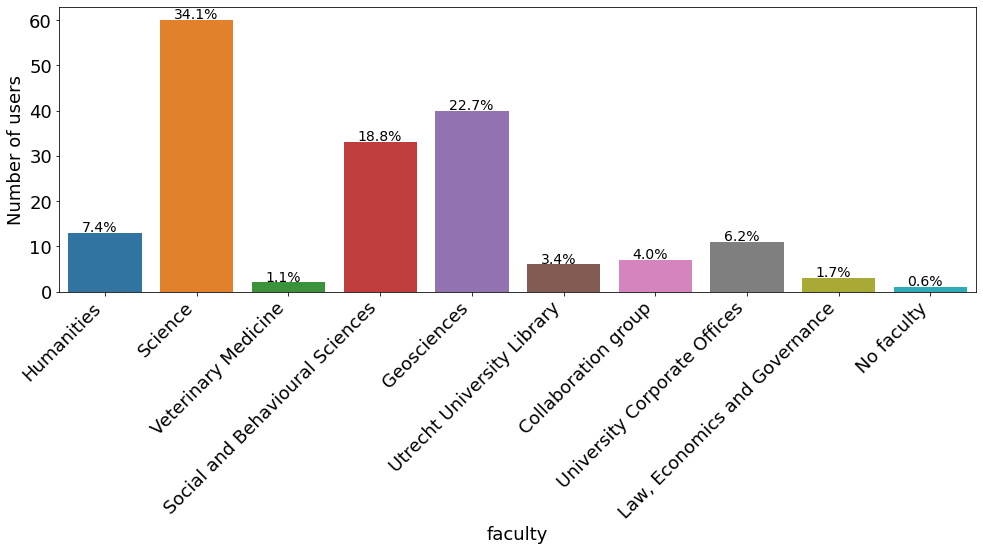

In [120]:
plt.rcParams['figure.figsize'] = [14, 8]
s = sns.countplot(x="faculty", data=df_annotated_users)
s.set_xticklabels(s.get_xticklabels(),rotation = 45, ha="right")
s.set_ylabel("Number of users")

add_percentages(s, df_annotated_users.faculty)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_count.png'))

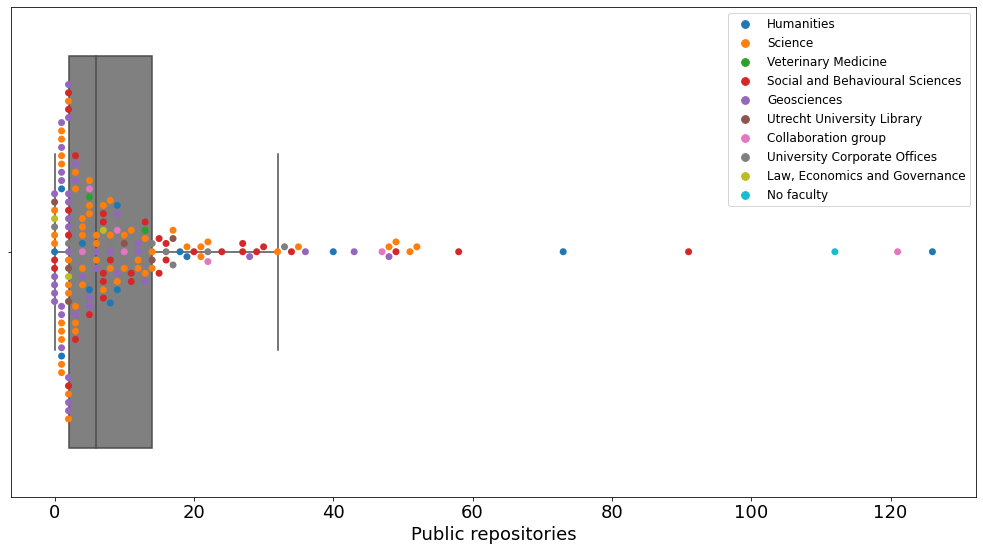

In [121]:
# create a boxplot with swarm
sns.boxplot(x='public_repos', data=df_annotated_users, color=".5", showfliers=False)
s = sns.swarmplot(x='public_repos', y=[""]*len(df_annotated_users), hue="faculty", data=df_annotated_users, size=7)
s.set_xlabel("Public repositories")

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_public_repos.png'))
# df_annotated_users[['user_id', 'public_repos', "faculty", "employee_type"]].loc[df_annotated_users["employee_type"] == "Organization"].sort_values('public_repos', ascending=False).head(10)

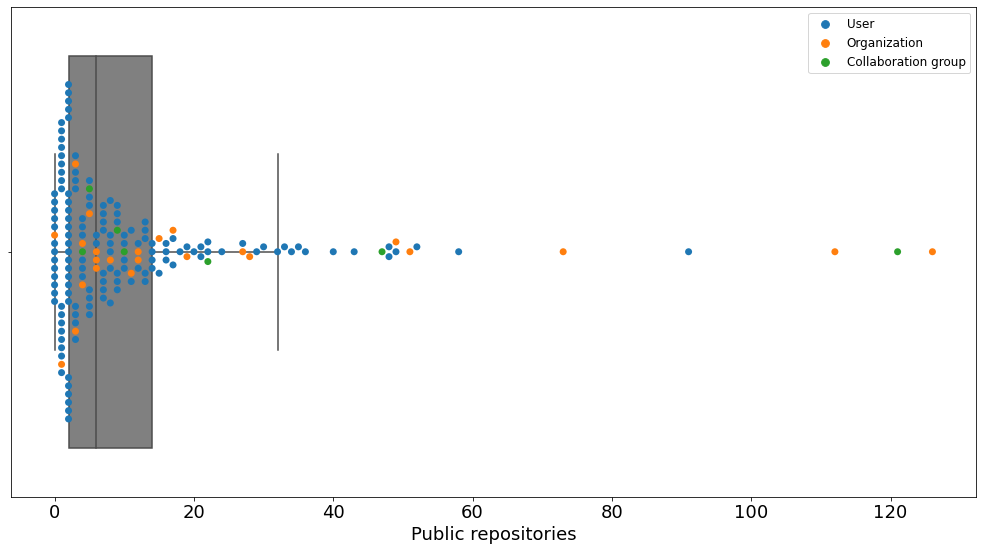

In [106]:
# create a boxplot with swarm
sns.boxplot(x='public_repos', data=df_annotated_users, color=".5", showfliers=False)
s = sns.swarmplot(x='public_repos', y=[""]*len(df_annotated_users), hue="employee_type", data=df_annotated_users, size=7, dodge=False)
s.set_xlabel("Public repositories")

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_public_repos_usertype.png'))

#### Extra user plots

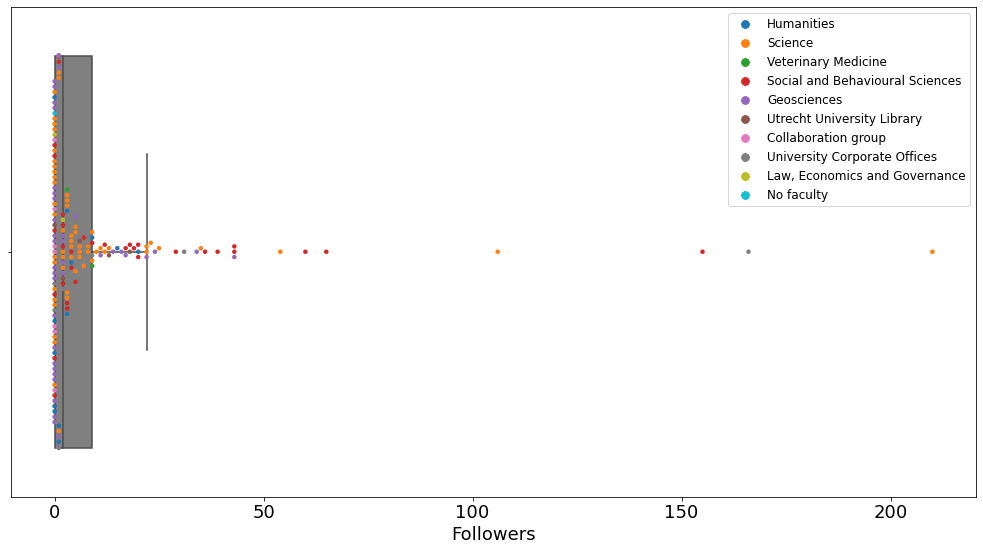

In [109]:
plt.rcParams['figure.figsize'] = [14, 8]
ax = sns.boxplot(x='followers', data=df_annotated_users, color=".5", showfliers=False)
ax = sns.swarmplot(x='followers', y=[""]*len(df_annotated_users), 
                   hue="faculty", data=df_annotated_users, size=4.5)
plt.legend(fontsize=12)
ax.set_xlabel("Followers")
plt.tight_layout()
plt.savefig(Path(fp_figs_extra, f'user_followers.png'))
# df_annotated_users[['user_id', 'followers']].sort_values('followers', ascending=False).head(10)

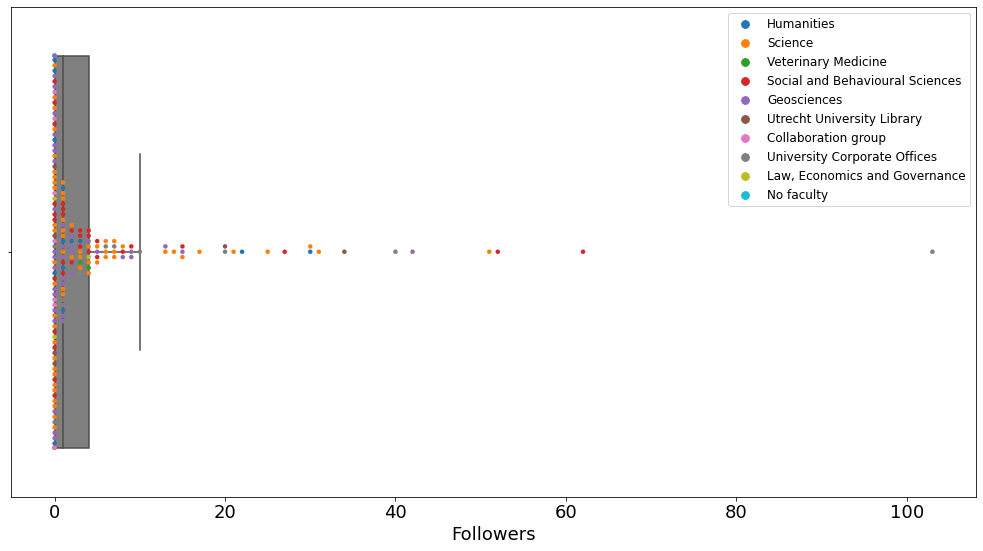

In [110]:
plt.rcParams['figure.figsize'] = [14, 8]
ax = sns.boxplot(x='following', data=df_annotated_users, color=".5", showfliers=False)
ax = sns.swarmplot(x='following', y=[""]*len(df_annotated_users), 
                   hue="faculty", data=df_annotated_users, size=4.5)
plt.legend(fontsize=12)
ax.set_xlabel("Followers")
plt.tight_layout()
plt.savefig(Path(fp_figs_extra, f'user_following.png'))
# df_annotated_users[['user_id', 'following']].sort_values('following', ascending=False).head(10)

Statistics table for users

In [ ]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

In [111]:
stats_users = df_annotated_users[["public_repos",
                                  "followers",
                                  "following"]].agg(["min", 
                                                     q25, 
                                                     "mean", 
                                                     "median", 
                                                     q75, 
                                                     "max",
                                                     "skew",
                                                     "kurt"])
index_names = ['Minimum', '25th percentile', 'Mean', 'Median', '75th percentile', 'Maximum', 'Skewness', 'Kurtosis']
stats_users.index = index_names
stats_users.columns = ["Public repositories","Followers","Following"]
stats_users = stats_users.round(2)
print(stats_users)
stats_users.to_latex(Path(fp_tables, "stats_users.tex"))

                 Public repositories  Followers  Following
Minimum                         0.00       0.00       0.00
25th percentile                 2.00       0.00       0.00
Mean                           13.02      10.32       5.44
Median                          6.00       2.00       1.00
75th percentile                14.00       9.00       4.00
Maximum                       126.00     210.00     103.00
Skewness                        3.31       5.16       4.32
Kurtosis                       13.19      30.98      24.24


## Load and preprocess all data


- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Load and preprocess data](#Load-and-preprocess-all-data)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#ANOVA)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)


Load (manually) filtered repositories and variables into notebook.

In [122]:
from datetime import date
import os
import statistics
from pathlib import Path
from pprint import pprint

import pandas as pd
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
import numpy as np
from scipy.spatial import distance

In [123]:
plt.rcParams.update({'font.size': 16})

In [170]:
repos = pd.read_excel(fp_repos)

repos["size"] = repos["size"]/1000  # scale size from kb to mb
repos.head()

C:\Users\beld\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,open_issues,watchers,default_branch,permissions,date,faculty,html_url_clickable,repo_type,Note,Label_date
0,247313888,MDEwOlJlcG9zaXRvcnkyNDczMTM4ODg=,AMWG,AJueling/AMWG,False,AJueling,https://github.com/AJueling/AMWG,CESM's AMWG analysis package for IMAU's simula...,False,https://api.github.com/repos/AJueling/AMWG,...,0,0,master,NaN,2022-07-18,Science,https://github.com/AJueling/AMWG,Rscript,NaN,08.08.2022
1,151547397,MDEwOlJlcG9zaXRvcnkxNTE1NDczOTc=,CESM,AJueling/CESM,False,AJueling,https://github.com/AJueling/CESM,NaN,False,https://api.github.com/repos/AJueling/CESM,...,0,1,master,NaN,2022-07-18,Science,https://github.com/AJueling/CESM,Rscript,NaN,08.08.2022
2,373423424,MDEwOlJlcG9zaXRvcnkzNzM0MjM0MjQ=,EC-Earth3-data,AJueling/EC-Earth3-data,False,AJueling,https://github.com/AJueling/EC-Earth3-data,intake-esm catalogues of EC-Earth3(P)-(HR) and...,False,https://api.github.com/repos/AJueling/EC-Earth...,...,0,0,main,NaN,2022-07-18,Science,https://github.com/AJueling/EC-Earth3-data,Rscript,NaN,08.08.2022
3,338361752,MDEwOlJlcG9zaXRvcnkzMzgzNjE3NTI=,FW-code,AJueling/FW-code,False,AJueling,https://github.com/AJueling/FW-code,code for doi:10.5194/os-2020-76,False,https://api.github.com/repos/AJueling/FW-code,...,0,0,main,NaN,2022-07-18,Science,https://github.com/AJueling/FW-code,Rscript,NaN,08.08.2022
4,143137715,MDEwOlJlcG9zaXRvcnkxNDMxMzc3MTU=,LEC,AJueling/LEC,False,AJueling,https://github.com/AJueling/LEC,Lorenz energy Cycle analysis of Parallel Ocean...,False,https://api.github.com/repos/AJueling/LEC,...,0,1,master,NaN,2022-07-18,Science,https://github.com/AJueling/LEC,Rscript,NaN,08.08.2022


Using the github API and the Howfairis software, we collected data on the repositories.

Namely, information about commits, contributors, howfairis variables, languages, readme related variables, test paths, topics, and version usage.

In [171]:
commits = pd.read_csv(fp_commits)
contributors = pd.read_csv(fp_contributors)
how_fair_is = pd.read_csv(fp_howfairis)
languages = pd.read_csv(fp_languages)
readme_variables = pd.read_csv(fp_readme_variables)
test_paths = pd.read_csv(fp_test_paths)
topics = pd.read_csv(fp_topics)
versions = pd.read_csv(fp_versions)

test_paths["has_test"] = pd.notna(test_paths["file_location"])
test_paths.drop("file_location",inplace=True, axis=1)

Preprocess data for merging. This removes the data column and renames the URL to be the same as in the repos dataframe.

In [172]:
def preprocess_extra_datasets(df):
    if "html_url_repository" in df.columns:
        df.rename(columns={"html_url_repository": "html_url"},inplace=True)
    if "date" in df.columns:
        df.drop('date', axis=1, inplace=True)
    else:
        print("Did not preprocess. Data is already preprocessed.")

preprocess_extra_datasets(commits)
preprocess_extra_datasets(contributors)
preprocess_extra_datasets(how_fair_is)
preprocess_extra_datasets(languages)
preprocess_extra_datasets(readme_variables)
preprocess_extra_datasets(test_paths)
preprocess_extra_datasets(topics)
preprocess_extra_datasets(versions)

Combine datasets. `Contributors`, `languages` and `topics` are 1:n datasets and can't be simply merged. Instead, we only retrieve the number of contributors, languages and topics per repository.

In [173]:
num_contributors = contributors.iloc[:,0].value_counts()
num_languages = languages["html_url"].value_counts()
num_topics = topics["html_url"].value_counts()

df_num_contributors = pd.DataFrame(np.array([num_contributors.index, num_contributors]).T, 
                                   columns=["html_url", "contributors_count"])
df_num_languages = pd.DataFrame(np.array([num_languages.index, num_languages]).T, 
                                   columns=["html_url", "languages_count"])
df_num_topics = pd.DataFrame(np.array([num_topics.index, num_topics]).T, 
                                   columns=["html_url", "topics_count"])

Merge repos

In [174]:
if repos.shape[1] <= 85:
    repos = pd.merge(repos, commits, how="left", on="html_url")
    repos = pd.merge(repos, how_fair_is, how="left", on="html_url")
    repos = pd.merge(repos, readme_variables, how="left", on="html_url")
    repos = pd.merge(repos, test_paths, how="left", on="html_url")
    repos = pd.merge(repos, versions, how="left", on="html_url")

    repos = pd.merge(repos, df_num_contributors, how="left", on="html_url")
    repos = pd.merge(repos, df_num_languages, how="left", on="html_url")
    repos = pd.merge(repos, df_num_topics, how="left", on="html_url")
    print("Merged repos.")

else:
    print("Repos are already merged. If not, reload data and execute again.")
repos.head()

Merged repos.


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,howfairis_citation,howfairis_checklist,has_install_instruction,has_usage_examples,has_contrib_guidelines,has_test,version_identifiable,contributors_count,languages_count,topics_count
0,247313888,MDEwOlJlcG9zaXRvcnkyNDczMTM4ODg=,AMWG,AJueling/AMWG,False,AJueling,https://github.com/AJueling/AMWG,CESM's AMWG analysis package for IMAU's simula...,False,https://api.github.com/repos/AJueling/AMWG,...,False,False,False,False,False,NaN,NaN,1,2,NaN
1,151547397,MDEwOlJlcG9zaXRvcnkxNTE1NDczOTc=,CESM,AJueling/CESM,False,AJueling,https://github.com/AJueling/CESM,NaN,False,https://api.github.com/repos/AJueling/CESM,...,False,False,False,False,False,True,NaN,1,3,NaN
2,373423424,MDEwOlJlcG9zaXRvcnkzNzM0MjM0MjQ=,EC-Earth3-data,AJueling/EC-Earth3-data,False,AJueling,https://github.com/AJueling/EC-Earth3-data,intake-esm catalogues of EC-Earth3(P)-(HR) and...,False,https://api.github.com/repos/AJueling/EC-Earth...,...,False,False,False,False,False,NaN,NaN,1,2,NaN
3,338361752,MDEwOlJlcG9zaXRvcnkzMzgzNjE3NTI=,FW-code,AJueling/FW-code,False,AJueling,https://github.com/AJueling/FW-code,code for doi:10.5194/os-2020-76,False,https://api.github.com/repos/AJueling/FW-code,...,True,False,False,False,False,NaN,True,1,2,NaN
4,143137715,MDEwOlJlcG9zaXRvcnkxNDMxMzc3MTU=,LEC,AJueling/LEC,False,AJueling,https://github.com/AJueling/LEC,Lorenz energy Cycle analysis of Parallel Ocean...,False,https://api.github.com/repos/AJueling/LEC,...,False,False,False,True,False,NaN,True,1,3,NaN


Fill missing FAIR variables with False. Missing counts are filled with 0s. The FAIR score is calculated as the sum of all FAIR variables.

In [175]:
howfairis_variables = ["howfairis_repository",
                       "howfairis_license",
                       "howfairis_registry",
                       "howfairis_citation",
                       "howfairis_checklist"]
new_fair_variables = ["vcs_usage", 
#                       "life_span", # life span not considered since it's not boolean
                      "repo_active",
                      "has_install_instruction",
                      "has_usage_examples",
                      "has_contrib_guidelines",
                      "has_test",
                      "version_identifiable"]
all_boolean_variables = howfairis_variables + new_fair_variables

# Fill missing values of booleans with False
repos.fillna(dict.fromkeys(all_boolean_variables, False),inplace=True)
repos["contributors_count"].fillna(1,inplace=True) # at least one contributor is needed
repos["topics_count"].fillna(0,inplace=True) 
repos["languages_count"].fillna(0,inplace=True) 
repos["fair_score"] = repos[all_boolean_variables].sum(axis=1)

Convert FAIR booleans to integers

In [176]:
repos[all_boolean_variables] = repos[all_boolean_variables].astype(int)
repos[all_boolean_variables].head(5)

,howfairis_repository,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist,vcs_usage,repo_active,has_install_instruction,has_usage_examples,has_contrib_guidelines,has_test,version_identifiable
0,1,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0
2,1,1,0,0,0,0,1,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,1,0,0,1


Create additional dataframes filtered by research-relation.

In [177]:
rs = ["RS", "Rscript", "RSWIP"]
rs_repos = repos.loc[repos['repo_type'].isin(rs)]

only_rs_repos = repos.loc[repos['repo_type']=="RS"]
only_rscript_repos = repos.loc[repos['repo_type']=="Rscript"]
only_rswip_repos = repos.loc[repos['repo_type']=="RSWIP"]

non_rs_repos = repos.loc[~repos['repo_type'].isin(rs)]

print(f"Number of repositories considered research software: {len(rs_repos.index)}")
print(f"Number of repositories considered non-research software: {len(non_rs_repos.index)}")

Number of repositories considered research software: 823
Number of repositories considered non-research software: 698


## Analysis of repositories


- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Load and preprocess data](#Load-and-preprocess-all-data)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#ANOVA)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

### Count of repositories in each faculty and repository type

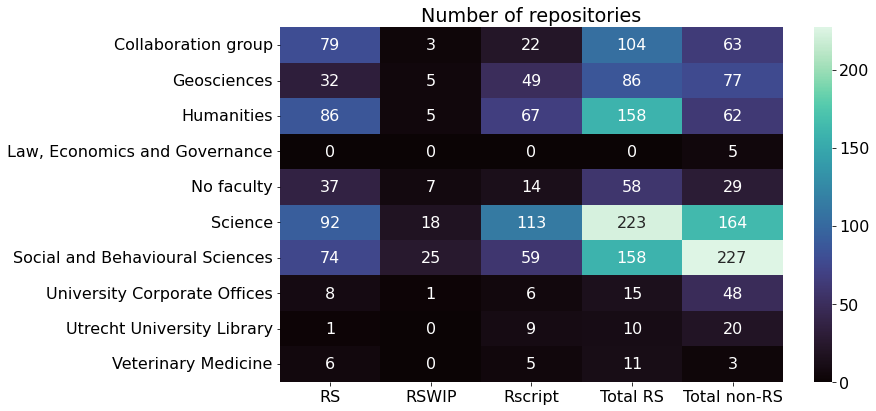

In [179]:
plt.rcParams['figure.figsize'] = [13, 6]
matrix_count = rs_repos.pivot_table(index="faculty", 
                                 columns="repo_type", 
                                 values="size", 
                                 aggfunc=len)
matrix_count_non_rs = non_rs_repos.pivot_table(index="faculty", 
                                             values="size", 
                                             aggfunc=len)

matrix_count_non_rs.rename(columns={"size": "Total non-RS"},inplace=True)
matrix_count["Total RS"] = matrix_count.sum(axis=1)

matrix_total = matrix_count_non_rs.join(matrix_count)
matrix_total.fillna(0,inplace=True)
matrix_total = matrix_total[["RS","RSWIP","Rscript","Total RS","Total non-RS"]]

s = sns.heatmap(matrix_total, 
                annot=True, 
                cmap=cmap,
                fmt='g')
s.set(title="Number of repositories", xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_repo_count.png'))

#### Further processing of data
Since we see here that some faculty groups are diminishingly small, we group the support-related groups together (University Corporate Offices, University Library, No faculty) and exclude Veterinary Medicine and Law, Economics and Governance from further analysis.

In [180]:
# Remove veterinary medicine and law, economics and governance faculties
repos_final = repos[~repos["faculty"].isin(["Veterinary Medicine", "Law, Economics and Governance"])]
# Group together support departments
repos_final["faculty"] = repos_final["faculty"].replace(dict.fromkeys(["No faculty", 
                                                                       "University Corporate Offices",
                                                                       "Utrecht University Library"], 
                                                                      "Support departments"))



rs_repos_final = repos_final.loc[repos_final['repo_type'].isin(rs)]
non_rs_repos_final = repos_final.loc[~repos_final['repo_type'].isin(rs)]


repos_final["faculty"].value_counts()

C:\Users\beld\AppData\Local\Temp/ipykernel_11952/3288225266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repos_final["faculty"] = repos_final["faculty"].replace(dict.fromkeys(["No faculty",


Science                            387
Social and Behavioural Sciences    385
Humanities                         220
Support departments                180
Collaboration group                167
Geosciences                        163
Name: faculty, dtype: int64

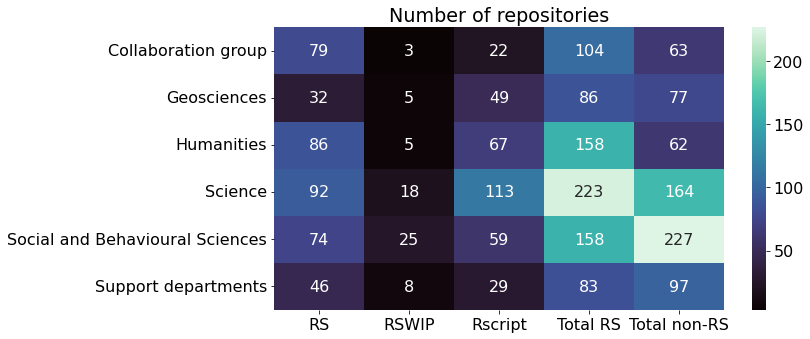

In [183]:
plt.rcParams['figure.figsize'] = [12, 5]
matrix_count = rs_repos_final.pivot_table(index="faculty", 
                                          columns="repo_type", 
                                          values="size", 
                                          aggfunc=len)
matrix_count_non_rs = non_rs_repos_final.pivot_table(index="faculty", 
                                                     values="size", 
                                                     aggfunc=len)

matrix_count_non_rs.rename(columns={"size": "Total non-RS"},inplace=True)
matrix_count["Total RS"] = matrix_count.sum(axis=1)

matrix_total = matrix_count_non_rs.join(matrix_count)
matrix_total.fillna(0,inplace=True)
matrix_total = matrix_total[["RS","RSWIP","Rscript","Total RS","Total non-RS"]]

s = sns.heatmap(matrix_total, 
                annot=True, 
                cmap=cmap,
                fmt='g')
s.set(title="Number of repositories", xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_repo_count_final.png'))

## Correlation analysis

Constants for heatmaps

In [184]:
cmap = "mako"
fill_value = None
xlabel= None
ylabel= None

In [185]:
print(f"Howfairis length: {len(how_fair_is)}")
print(f"commits length: {len(commits)}")
print(f"readme_variables length: {len(readme_variables)}")
print(f"test_paths length: {len(test_paths)}")
print(f"versions length: {len(versions)}")
versions["version_identifiable"].value_counts()

Howfairis length: 1517
commits length: 1502
readme_variables length: 1317
test_paths length: 338
versions length: 336


True     268
False     68
Name: version_identifiable, dtype: int64

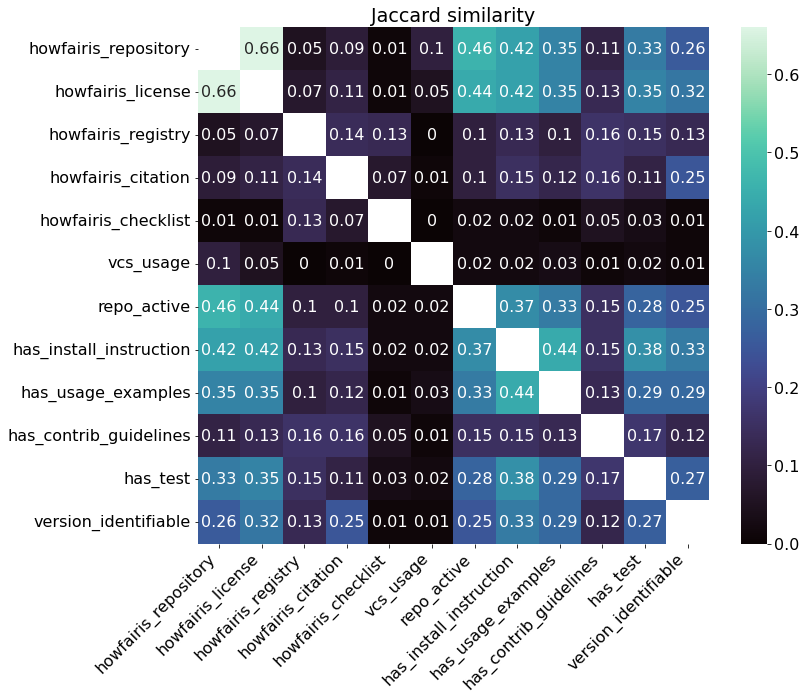

In [188]:
plt.rcParams['figure.figsize'] = [12, 10]

matrix_size = len(all_boolean_variables)
distances = np.zeros(shape=(matrix_size,matrix_size))
for i in range(matrix_size-1): 
    for j in range(i+1, matrix_size):
        distances[i][j] = round(distance.jaccard(rs_repos_final[all_boolean_variables[i]],
                                                 rs_repos_final[all_boolean_variables[j]]),2)

        
i_lower = np.tril_indices(matrix_size, -1)
distances[i_lower] = distances.T[i_lower]  # make the matrix symmetric
        
distances[distances == 0] = np.nan # remove zeros from plot
similarity = 1-distances # turn distance to similarity
pd_similarity = pd.DataFrame(similarity)
pd_similarity.columns = all_boolean_variables
pd_similarity.index = all_boolean_variables

# pd_similarity.drop("version_identifiable",inplace=True,axis=0)
# pd_similarity.drop("howfairis_repository",inplace=True,axis=1)

s = sns.heatmap(pd_similarity, annot=True, cmap=cmap)
s.set_xticklabels(s.get_xticklabels(),rotation = 45, ha="right")
s.set(title="Jaccard similarity")
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_jaccard_similarity.png'))

## Heatmaps

The heatmaps show averages or total counts over the two dimensions `faculty` and `repository type`

In [189]:
def plot_heatmap(repos, value, aggfunc=np.mean, fill_value=None, xlabel=None, ylabel=None, title=None):
    plt.rcParams['figure.figsize'] = [10, 6]
    matrix = repos.pivot_table(index="faculty", 
                              columns="repo_type", 
                              values=value, 
                              aggfunc=aggfunc,
                              fill_value=fill_value)
    matrix_total = repos.pivot_table(index="faculty", 
                                        values=value,              
                                        aggfunc=aggfunc,
                                        fill_value=fill_value)

    matrix["Total"] = matrix_total[value]
    matrix = matrix.round(2)

    s = sns.heatmap(matrix, 
                    annot=True, 
                    cmap=cmap,
                    fmt='g')

    s.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.tight_layout()
    plt.savefig(Path(fp_figs, f'heatmap_{value}.png'))

Global settings for other heatmaps

### Stargazers

Stargazers represent the amount of people that have 'starred' a Github project. Starring a project can indicate that a user likes the project. It can also be used to bookmark a project, since starred projects are saved. The amount of stargazers can be used as a metric to measure popularity. 

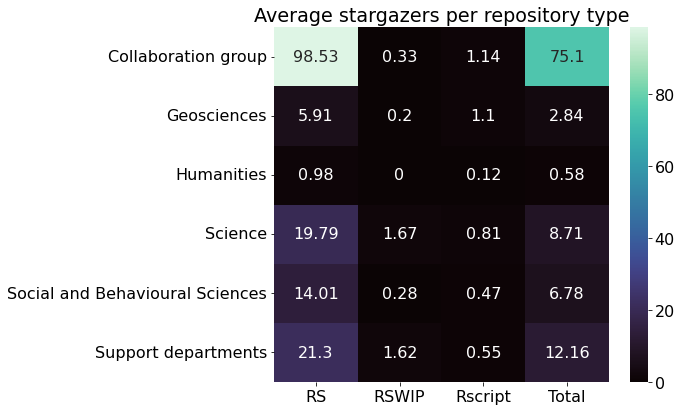

In [190]:
value = "stargazers_count"
aggfunc = np.mean
title = "Average stargazers per repository type"


plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

### Watchers

Watchers receive  notifications about project activity. The number of watchers is equal to that of stargazers as described here: https://github.com/orgs/community/discussions/24795

Retrieving the subscriber count is not part of the used API request to retrieve repositories: https://docs.github.com/en/rest/repos/repos#list-repositories-for-a-user

It would be necessary to retrieve each repository individually via this request: https://docs.github.com/en/rest/repos/repos#get-a-repository

Therefore, watchers are not part of the analysis.

### Open issues

An issue is way to keep track of the tasks, enhancements and bugs of the project. They can be discussed in a thread by users and developers. Each repository can enable their own issue page. An issue can be open, for example when a new bug is found, or closed, when it is solved. This shows the amount of open issues a repository has.

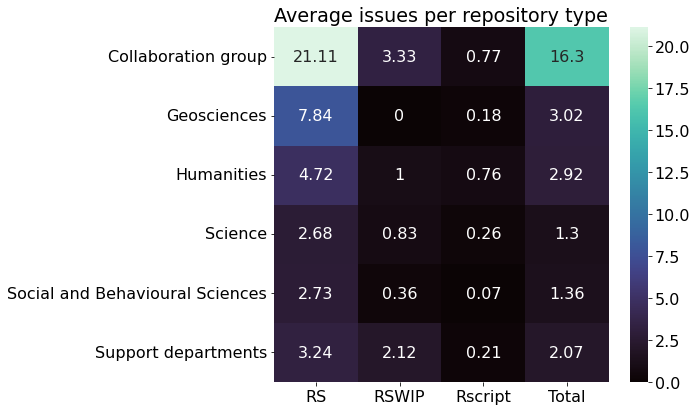

In [191]:
value = "open_issues"
aggfunc = np.mean
title = "Average issues per repository type"


plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

### Fork count

A fork is a copy of a repository for another user.

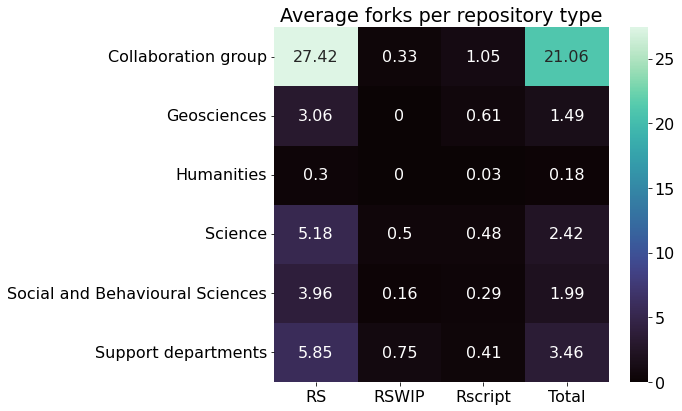

In [193]:
value = "forks"
aggfunc = np.mean
title = "Average forks per repository type"


plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

### Size
The size of a repository in kb. This relies on Git alternates. More details can be found here: https://stackoverflow.com/questions/8646517/how-can-i-see-the-size-of-a-github-repository-before-cloning-it/8679592#8679592 There is no official documentation of size calculation.

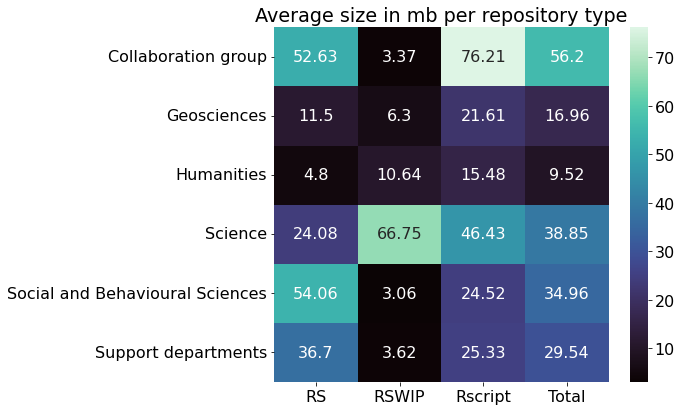

In [194]:
value = "size"
aggfunc = np.mean
title = "Average size in mb per repository type"


plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

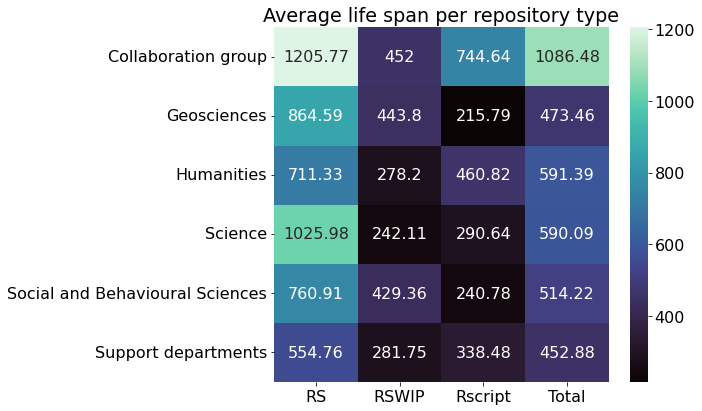

In [195]:
value = "life_span"
aggfunc = np.mean
title = "Average life span per repository type"


plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

### FAIR variables

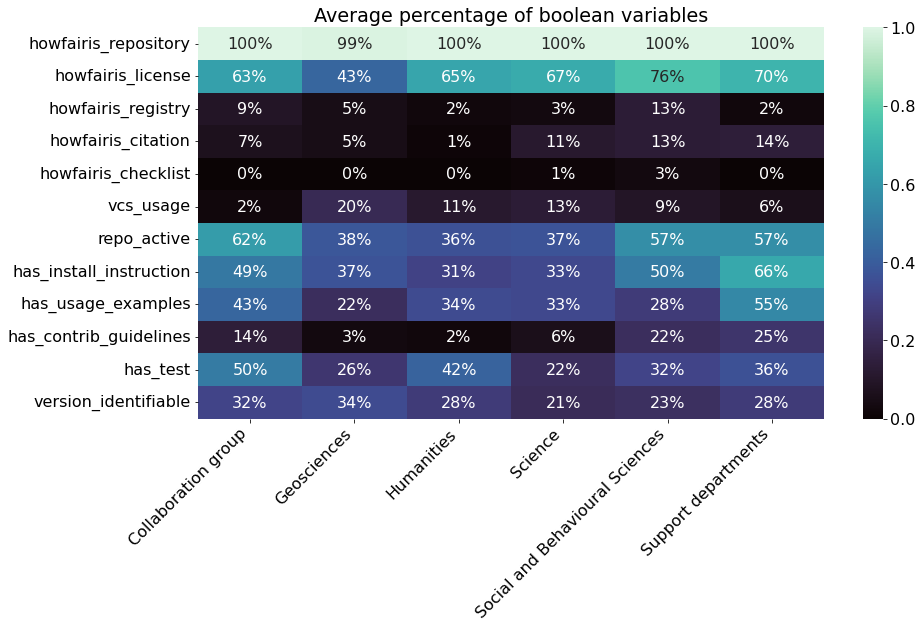

In [197]:
plt.rcParams['figure.figsize'] = [14, 9]
value = all_boolean_variables
aggfunc = np.mean
title = "Average percentage of boolean variables"

matrix = rs_repos_final.pivot_table(index="faculty", 
#                           columns="repo_type", 
                           values=all_boolean_variables, 
                           aggfunc=aggfunc,
#                            sort=False,
                           fill_value=fill_value)
matrix = matrix.round(2).T
matrix = matrix.reindex(all_boolean_variables)

s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt=".0%")

s.set_xticklabels(s.get_xticklabels(),rotation = 45, ha="right")
s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_fair_booleans.png'))

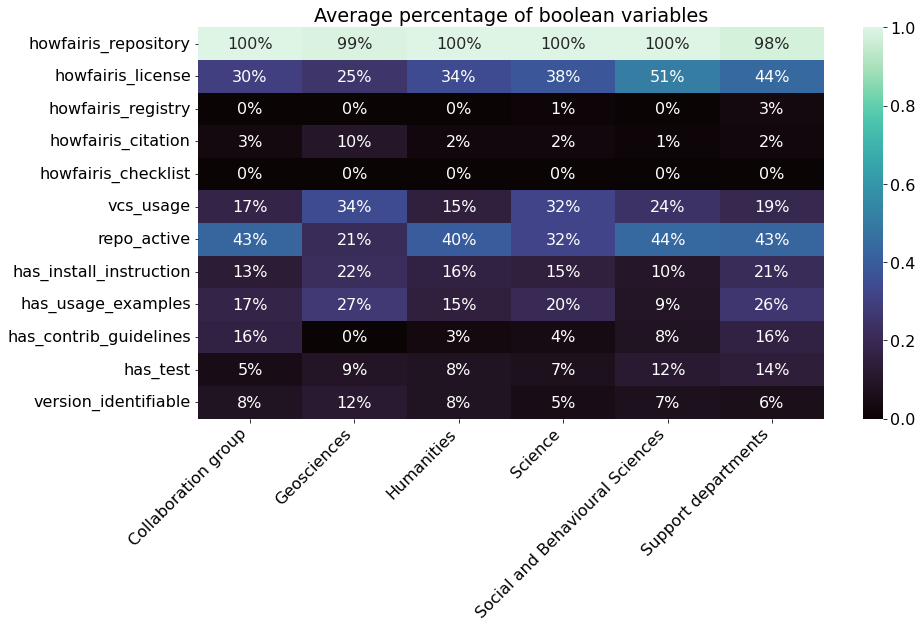

In [198]:
plt.rcParams['figure.figsize'] = [14, 9]
value = all_boolean_variables
aggfunc = np.mean
title = "Average percentage of boolean variables"

matrix = non_rs_repos_final.pivot_table(index="faculty", 
#                           columns="repo_type", 
                           values=all_boolean_variables, 
                           aggfunc=aggfunc,
#                            sort=False,
                           fill_value=fill_value)
matrix = matrix.round(2).T
matrix = matrix.reindex(all_boolean_variables)

s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt=".0%")

s.set_xticklabels(s.get_xticklabels(),rotation = 45, ha="right")
s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_fair_booleans.png'))

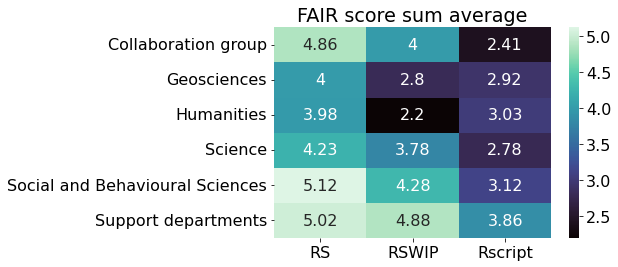

In [202]:
plt.rcParams['figure.figsize'] = [9, 4]
value = "fair_score"
aggfunc = np.mean
title = "Average percentage of boolean variables"

matrix = rs_repos_final.pivot_table(index="faculty", 
                          columns="repo_type", 
                           values="fair_score", 
                           aggfunc=aggfunc,
                           fill_value=fill_value)

matrix = matrix.round(2)
matrix

title = "FAIR score sum average"

s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='g')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_{value}.png'))

## ANOVA

- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#ANOVA)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

First, we want to inspect the distribution of the numeric variables. This is done by visualizing the histograms.

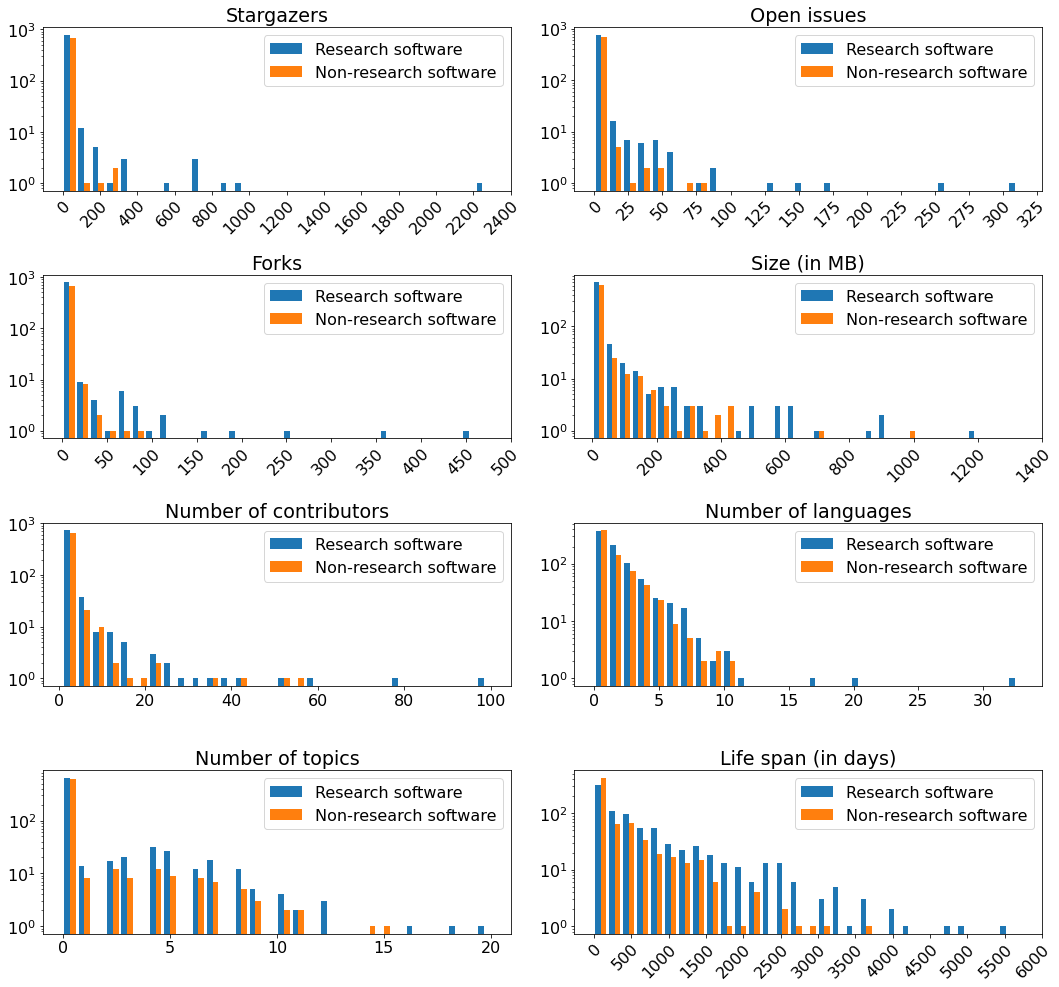

In [209]:
plt.rcParams['figure.figsize'] = [15, 14]
fig, ax = plt.subplots(4, 2)
label_non_rs = ["Research software", "Non-research software"]
label_rs = ["Research software", "Research scripts", "RSWIP"]


rotation=45
plot_var = "stargazers_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=200
title="Stargazers"
ax[0,0].hist(cols,bins=30, label=label_non_rs)
ax[0,0].set_yscale("log")
ax[0,0].legend(loc='upper right')
ax[0,0].set_title(title)
ax[0,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks), 
                        rotation=rotation, ha="right", rotation_mode='anchor')

# # plt.savefig(Path(fp_figs, f'hist_{var_name}.png'))


plot_var = "open_issues"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=25
title="Open issues"
ax[0,1].hist(cols,bins=30, label=label_non_rs)
ax[0,1].set_yscale("log")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title(title)
ax[0,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "forks"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=50
title="Forks"
ax[1,0].hist(cols,bins=30, label=label_non_rs)
ax[1,0].set_yscale("log")
ax[1,0].legend(loc='upper right')
ax[1,0].set_title(title)
ax[1,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[1,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "size"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=200
title="Size (in MB)"
ax[1,1].hist(cols,bins=30, label=label_non_rs)
ax[1,1].set_yscale("log")
ax[1,1].legend(loc='upper right')
ax[1,1].set_title(title)
ax[1,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[1,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "contributors_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=25
title="Number of contributors"
ax[2,0].hist(cols,bins=30, label=label_non_rs)
ax[2,0].set_yscale("log")
ax[2,0].legend(loc='upper right')
ax[2,0].set_title(title)
# ax[2,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
# ax[2,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
#                         rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "languages_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=25
title="Number of languages"
ax[2,1].hist(cols,bins=30, label=label_non_rs)
ax[2,1].set_yscale("log")
ax[2,1].legend(loc='upper right')
ax[2,1].set_title(title)


plot_var = "topics_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=5
title="Number of topics"
ax[3,0].hist(cols,bins=30, label=label_non_rs)
ax[3,0].set_yscale("log")
ax[3,0].legend(loc='upper right')
ax[3,0].set_title(title)
ax[3,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))

plot_var = "life_span"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=500
title="Life span (in days)"
ax[3,1].hist(cols,bins=30, label=label_non_rs)
ax[3,1].set_yscale("log")
ax[3,1].legend(loc='upper right')
ax[3,1].set_title(title)
ax[3,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'histograms.png'))

### Table with numerical variables

In [207]:
# TODO: how to best create table? for RS vs non-RS

# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

stats_repos = repos_final[["stargazers_count",
                           "open_issues",
                           "forks",
                           "size",
                           "contributors_count",
                           "languages_count",
                           "topics_count",
                           "life_span"]].agg(["min", 
                                              q25,
                                              "mean",
                                              "median",
                                              q75,
                                              "max",
                                              "skew",
                                              "kurt"]).round(2)
stats_repos
# 7 of these tables

,stargazers_count,open_issues,forks,size,contributors_count,languages_count,topics_count,life_span
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
q25,0.00,0.00,0.00,0.05,1.00,1.00,0.00,5.50
mean,9.41,2.49,2.96,26.11,2.35,1.98,0.83,463.08
median,0.00,0.00,0.00,0.75,1.00,1.00,0.00,182.00
q75,2.00,0.00,1.00,8.94,2.00,3.00,0.00,611.50
max,2286.00,314.00,461.00,1209.65,100.00,33.00,20.00,5609.00
skew,19.26,13.35,15.49,6.69,10.06,4.40,3.36,2.55
kurt,478.14,230.08,297.07,56.64,130.87,48.50,13.57,8.44


In [208]:
col_names = ["Stargazers", "Issues", "Forks", "Size", "Contributors", "Languages", "Topics", "Life span"]
stats_repos.columns = col_names
index_names = ['Minimum', '25th percentile', 'Mean', 'Median', '75th percentile', 'Maximum', 'Skewness', 'Kurtosis']
stats_repos.index = index_names
stats_repos = stats_repos
stats_repos.to_latex(Path(fp_tables, "stats_repos.tex"))
print("Exported tex table")

Exported tex table


## Analysis of FAIR and nested variables

- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Repository analysis](#Analysis-of-repository-collection)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

In [ ]:
from datetime import date
import statistics
from collections import Counter
from pathlib import Path
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns

## Sofware licenses 

A license is important because it shows that people have permission to use and modify your code. The plots below show the licenses used in the collection. 


In [90]:
# short names for licenses
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense',
    'GNU Affero General Public License v3.0': 'AGPPLv3',
    'BSD 2-Clause "Simplified" License': 'BSD 2-Clause',
    'Mozilla Public License 2.0': 'MPL 2.0',
    'GNU Lesser General Public License v2.1': 'LGPLv2.1',
    'Creative Commons Attribution Share Alike 4.0 International': 'CC-BY-SA',
    'ISC License': 'ISC'
    
}
# top_10_licenses_short = repos["license"].replace(licenses_abbr)

repos["license_short"] = repos["license"].replace(licenses_abbr)
rs_repos

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,has_install_instruction,has_usage_examples,has_contrib_guidelines,has_test,version_identifiable,contributors_count,languages_count,topics_count,fair_score,license_short
0,247313888,MDEwOlJlcG9zaXRvcnkyNDczMTM4ODg=,AMWG,AJueling/AMWG,False,AJueling,https://github.com/AJueling/AMWG,CESM's AMWG analysis package for IMAU's simula...,False,https://api.github.com/repos/AJueling/AMWG,...,0,0,0,0,0,1,2,0,2,BSD 2-Clause
1,151547397,MDEwOlJlcG9zaXRvcnkxNTE1NDczOTc=,CESM,AJueling/CESM,False,AJueling,https://github.com/AJueling/CESM,NaN,False,https://api.github.com/repos/AJueling/CESM,...,0,0,0,1,0,1,3,0,2,NaN
2,373423424,MDEwOlJlcG9zaXRvcnkzNzM0MjM0MjQ=,EC-Earth3-data,AJueling/EC-Earth3-data,False,AJueling,https://github.com/AJueling/EC-Earth3-data,intake-esm catalogues of EC-Earth3(P)-(HR) and...,False,https://api.github.com/repos/AJueling/EC-Earth...,...,0,0,0,0,0,1,2,0,3,Unlicense
3,338361752,MDEwOlJlcG9zaXRvcnkzMzgzNjE3NTI=,FW-code,AJueling/FW-code,False,AJueling,https://github.com/AJueling/FW-code,code for doi:10.5194/os-2020-76,False,https://api.github.com/repos/AJueling/FW-code,...,0,0,0,0,1,1,2,0,5,BSD 3-Clause
4,143137715,MDEwOlJlcG9zaXRvcnkxNDMxMzc3MTU=,LEC,AJueling/LEC,False,AJueling,https://github.com/AJueling/LEC,Lorenz energy Cycle analysis of Parallel Ocean...,False,https://api.github.com/repos/AJueling/LEC,...,0,1,0,0,1,1,3,0,4,BSD 3-Clause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,81915236,MDEwOlJlcG9zaXRvcnk4MTkxNTIzNg==,ants,wouter-swierstra/ants,False,wouter-swierstra,https://github.com/wouter-swierstra/ants,AFP 2017 Ants exercise,False,https://api.github.com/repos/wouter-swierstra/...,...,0,0,0,0,0,2,1,0,1,NaN
1508,4482570,MDEwOlJlcG9zaXRvcnk0NDgyNTcw,Bird,wouter-swierstra/Bird,False,wouter-swierstra,https://github.com/wouter-swierstra/Bird,Formalization of Richard Bird's Pearls of Func...,False,https://api.github.com/repos/wouter-swierstra/...,...,0,0,0,0,0,1,1,0,1,NaN
1514,207575027,MDEwOlJlcG9zaXRvcnkyMDc1NzUwMjc=,hbral,wouter-swierstra/hbral,False,wouter-swierstra,https://github.com/wouter-swierstra/hbral,Hetergeneous binary random-access lists,False,https://api.github.com/repos/wouter-swierstra/...,...,0,0,0,0,0,1,1,0,2,BSD 3-Clause
1517,105548131,MDEwOlJlcG9zaXRvcnkxMDU1NDgxMzE=,predicate-transformers,wouter-swierstra/predicate-transformers,False,wouter-swierstra,https://github.com/wouter-swierstra/predicate-...,NaN,False,https://api.github.com/repos/wouter-swierstra/...,...,0,0,0,0,1,2,3,0,2,NaN


In [89]:
rs_repos.groupby(["faculty","repo_type"])["license_short"].agg({pd.Series.mode})


mode
faculty                         repo_type                
Collaboration group             RS                    MIT
                                RSWIP                 MIT
                                Rscript               MIT
Geosciences                     RS                  GPLv3
                                RSWIP                 MIT
                                Rscript      [GPLv3, MIT]
Humanities                      RS           [GPLv2, MIT]
                                RSWIP               Other
                                Rscript             GPLv2
No faculty                      RS                    MIT
                                RSWIP      [GPLv3, Other]
                                Rscript               MIT
Science                         RS             Apache 2.0
                                RSWIP                 MIT
                                Rscript               MIT
Social and Behavioural Sciences RS                  Other
                                RSWIP               GPLv3
                                Rscript      [GPLv3, MIT]
University Corporate Offices    RS                    MIT
                                RSWIP               GPLv3
                                Rscript               MIT
Utrecht University Library      RS                     []
                                Rscript               MIT
Veterinary Medicine             RS                  GPLv3
                                Rscript             GPLv3

In [92]:
# repos[["license","faculty","repo_type"]].crosstab()

matrix = rs_repos.pivot_table(index="faculty", 
                          columns="repo_type", 
                           values="license_short",
                           aggfunc=pd.Series.mode)
#                            fill_value=fill_value)

matrix

repo_type,RS,RSWIP,Rscript
faculty,,,
Collaboration group,MIT,MIT,MIT
Geosciences,GPLv3,MIT,"[GPLv3, MIT]"
Humanities,"[GPLv2, MIT]",Other,GPLv2
No faculty,MIT,"[GPLv3, Other]",MIT
Science,Apache 2.0,MIT,MIT
Social and Behavioural Sciences,Other,GPLv3,"[GPLv3, MIT]"
University Corporate Offices,MIT,GPLv3,MIT
Utrecht University Library,[],NaN,MIT
Veterinary Medicine,GPLv3,NaN,GPLv3


In [ ]:
# top most used 10 licences
top_10_licenses = repos["license"].value_counts().head(10)
print(top_10_licenses)

In [ ]:
ax = sns.barplot(top_10_licenses.index, top_10_licenses)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_first10_{subset}.png'), bbox_inches="tight")

In [ ]:
top_10_licenses_short = repos["license"].replace(licenses_abbr).value_counts().head(10)
print(top_10_licenses_short)

# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_short_first10_{subset}.png'), bbox_inches="tight")

In [ ]:
# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short / top_10_licenses_short.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular licenses (in %)")

plt.savefig(Path(fp_figs, f'licenses_short_first10_percentage_{subset}.png'), bbox_inches="tight")

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [ ]:
percentage_license = round(float(repos["license"].isna().sum()/len(repos)* 100),2)
print("{} % of repositories have a license on their page".format(percentage_license))

## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

### Jupyter Notebooks

Please note that due to the way GitHub calculates the dominant language in a repository, Jupyter Notebooks tend to be the top language if used in a repository. The top language is determined by the number of characters, which is usually much larger in Jupyter Notebook files compared to for example Python scripts.

In [ ]:
repos["language"].value_counts().shape

In [ ]:
repos["language"].value_counts().plot.bar(figsize = (100,50), fontsize = 100)
plt.title("Programming languages by popularity", fontsize = 100)
plt.savefig(Path(fp_figs, f'language_{subset}.png'), bbox_inches="tight")

In [ ]:
repos["language"].value_counts().head(20).plot.barh(figsize = (50,50), fontsize = 100)
plt.title("Top 20 Programming languages", fontsize = 100)
plt.gca().invert_yaxis()
plt.savefig(Path(fp_figs, f'language_top20_{subset}.png'), bbox_inches="tight")

In [ ]:
top_10_languages = repos["language"].value_counts().drop(["HTML", "TeX"]).head(10)

ax = sns.barplot(top_10_languages.index, top_10_languages / top_10_languages.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular languages (in %)")

plt.savefig(Path(fp_figs, f'language_top10_{subset}.png'), bbox_inches="tight")

In [ ]:
repo_languages_rel = repos["language"].value_counts().head(10) / len(repos)
repo_languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Relative occurence languages

In [ ]:
repo_languages_rel

In [ ]:
languages_rel = languages["language"].value_counts().head(10) / len(repos)
languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 occuring programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'occurence_language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Topics

Topics describe the context of the repository. 

In [ ]:
topics['topic'].value_counts().nlargest(50)

In [ ]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'Top 10 topics')
plt.savefig(Path(fp_figs, f'most_occuring_topics_top10_{subset}.png'), bbox_inches="tight")


## Number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


In [ ]:
contributors['html_url_repository'].value_counts().plot.hist(x = 'contributors', figsize = (10,10), fontsize = 12, title = 'Number of contributors')
plt.savefig(Path(fp_figs, f'contributors_{subset}.png'), bbox_inches="tight")


In [ ]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


In [ ]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [ ]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

In [ ]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfairis sumscore')
plt.savefig(Path(fp_figs, f'howfairissum_boxplot_{subset}.png'), bbox_inches="tight")
